# <span style="color:red"> Main Modelling - SVM - Gridsearch </span>
* read in pickle
* keep 3 translators
* final selected features based on initial analysis with logistic regression
* drop 'A Wild Sheep Chase' due to unique text
* run XGboosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.preprocessing import label_binarize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import class to run modelling steps
from translator_modelling import Modelling

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [13]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
df.shape

(5212, 142)

### Check the baseline

In [15]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.39927091327705294

### SVM rbf kernel gridsearch

In [4]:
# prepare modelling
model = SVC(gamma='auto', kernel='rbf', probability=True,)
svm = Modelling(df, model)

# select feature groups for modelling
predictor_cols = svm.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = svm.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = svm.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {
    "C":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "gamma":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "shrinking": [True, False]
    }

svm.gridsearch(params, X_train, y_train)

# score the fitted model
svm_gs_01_results = svm.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'svm_gs_01'
out_full_path = out_path + out_name + '.pkl'
svm.save_model(out_full_path)

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 23.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 51.8min
[Parallel(n_jobs=2)]: Done 490 out of 490 | elapsed: 61.3min finished


Best Parameters:
{'C': 100, 'gamma': 0.001, 'shrinking': True}
Best estimator mean cross validated training score:
0.6896096568123653
Best estimator score on the full training set:
0.9066922523386903
Best estimator score on the test set:
0.7037392138063279
ROC-AUC score on the test set:
Class 0: 0.87
Class 1: 0.86
Class 2: 0.88


In [7]:
# prepare modelling
model = LinearSVC()
svm_l = Modelling(df, model)

# select feature groups for modelling
predictor_cols = svm_l.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = svm_l.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = svm_l.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {
    "C":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    }

svm_l.gridsearch(params, X_train, y_train)

# # score the fitted model
# svm_l_gs_01_results = svm_l.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'svm_l_gs_01'
out_full_path = out_path + out_name + '.pkl'
svm_l.save_model(out_full_path)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed:   34.8s finished


In [8]:
print('train score:', svm_l.model_gs.score(X_train, y_train))
print('CV score:', svm_l.model_gs.best_score_)
print('test score:', svm_l.model_gs.score(X_test, y_test))

train score: 0.7004077716478772
CV score: 0.6749810715653168
test score: 0.6903163950143816


In [9]:
svm_l.model_gs.best_estimator_.coef_

array([[ 0.36971322, -0.05294094,  0.15908526,  0.07346794,  0.17427653,
         0.08816843,  0.28100341, -0.00896543, -0.09240378, -0.29435223,
        -0.19652899, -0.14134296,  0.04456161, -0.08503255, -0.1231396 ,
        -0.023788  , -0.03012599, -0.17687931, -0.00573963, -0.12580471,
         0.05528554,  0.09372989,  0.03457766, -0.01114146, -0.03751258,
        -0.04978   ,  0.15256938, -0.13425168,  0.00279624, -0.14925311,
         0.06943541, -0.02201628, -0.02506339, -0.04628662,  0.01744331,
         0.03067261,  0.08483645,  0.00899222,  0.00302848, -0.00586166,
         0.01518538, -0.01461595, -0.05827985,  0.07543703,  0.02579427,
         0.02633296, -0.04130709,  0.0321893 ,  0.00877891,  0.02520021,
        -0.01105223,  0.03271582, -0.01860935, -0.0029131 , -0.01705547,
        -0.04382157,  0.00088327, -0.03890619,  0.01380099, -0.04492027,
        -0.03807867, -0.05991245,  0.03157311, -0.02246541,  0.01301897,
        -0.02130072,  0.02033608, -0.02824541, -0.0

In [24]:
# X_train.columns

Index(['n_sents_norm', 'n_words_norm', 'n_chars_norm', 'n_syllables_norm',
       'n_unique_words_norm', 'n_long_words_norm', 'n_monosyllable_words_norm',
       'n_polysyllable_words_norm', 'pron_count_norm', 'verb_count_norm',
       'det_count_norm', 'adj_count_norm', 'noun_count_norm', 'adp_count_norm',
       'cconj_count_norm', 'sconj_count_norm', 'adv_count_norm',
       'aux_count_norm', 'part_count_norm', 'propn_count_norm',
       'intj_count_norm', 'the_w', 'to_w', 'and_w', 'of_w', 'you_w', 'was_w',
       'he_w', 'she_w', 'had_w', 'said_w', 'like_w', 'just_w', 'time_w',
       'know_w', 'think_w', 'got_w', 'right_w', 'new_adj', 'other_adj',
       'more_adj', 'small_adj', 'deep_adj', 'whole_adj', 'first_adj',
       'bad_adj', 'little_adj', 'next_adj', 'much_adj', 'own_adj', 'hard_adj',
       'last_adj', 'only_adj', 'big_adj', 'right_adj', 'long_adj', 'old_adj',
       'strange_adj', 'same_adj', 'young_adj', 'sure_adj', 'able_adj',
       'real_adj', 'different_adj', 'good

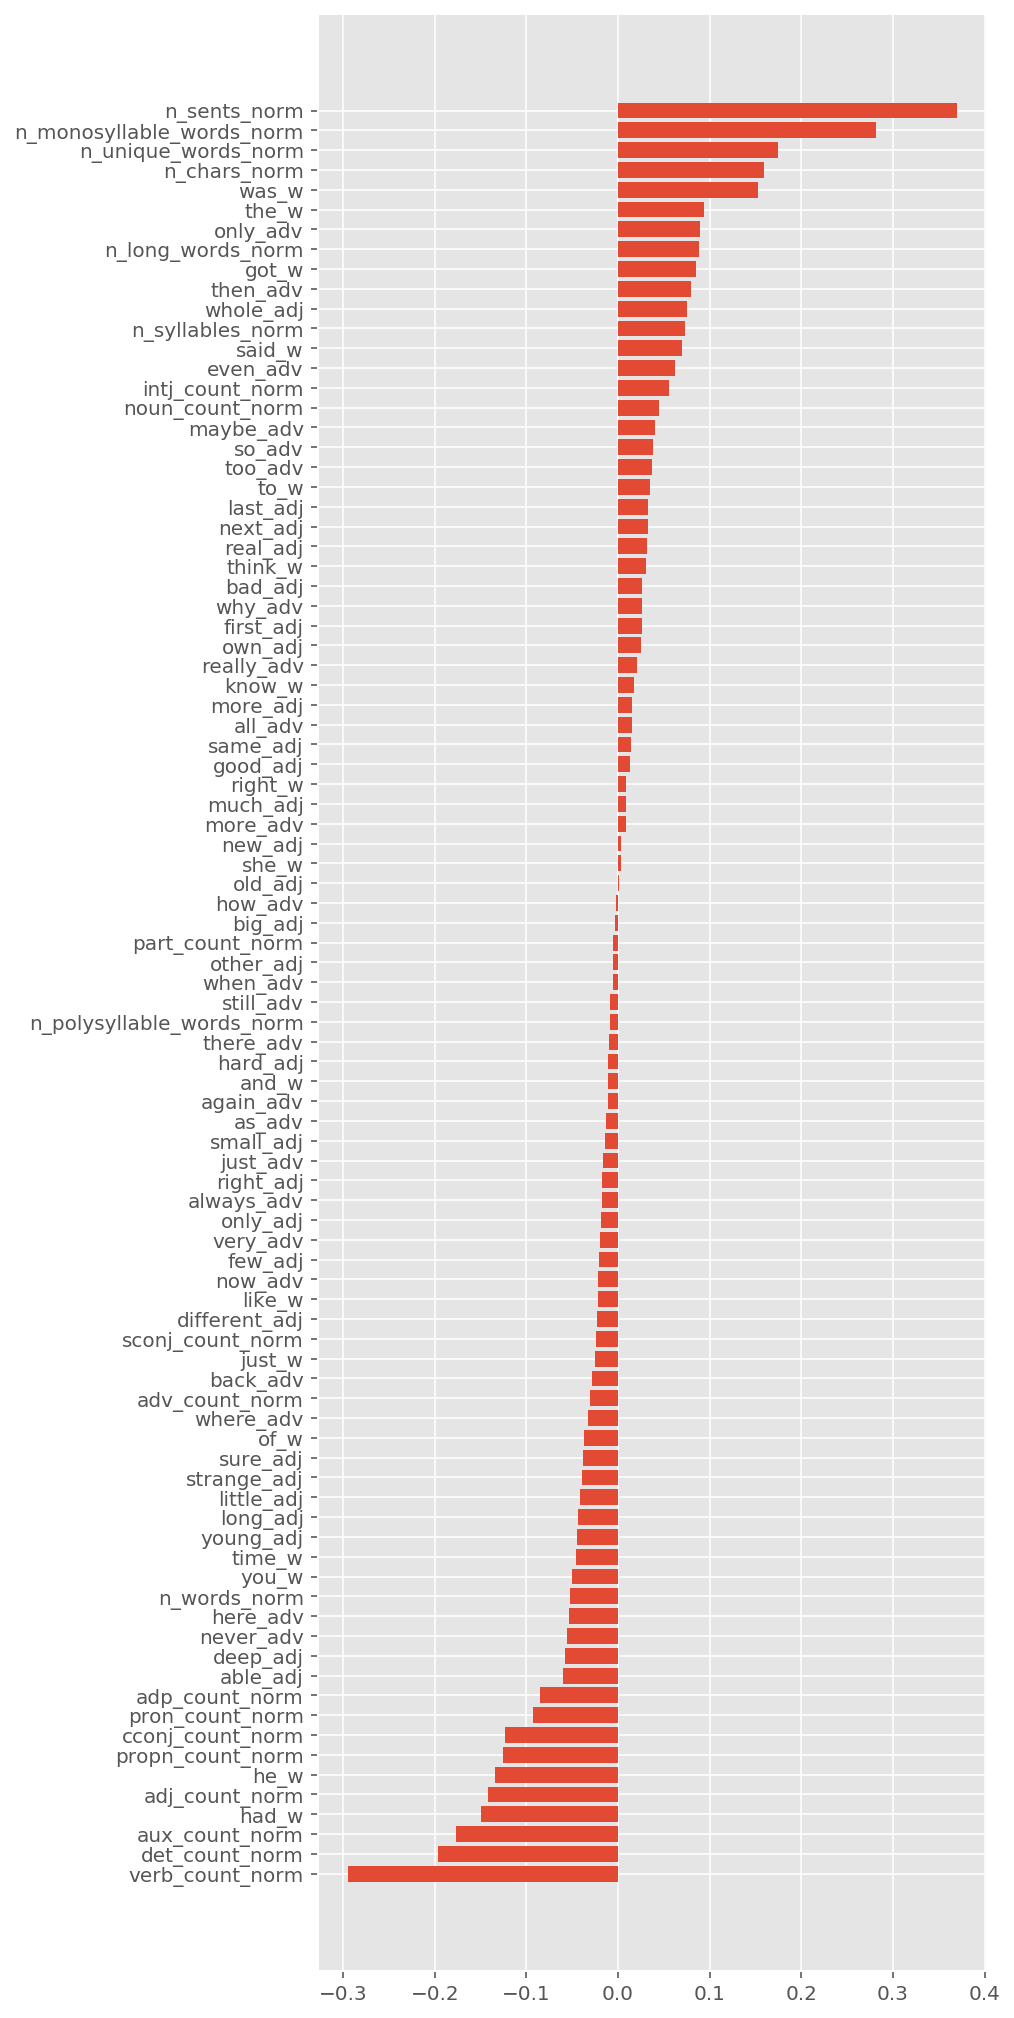

In [10]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    fig, ax = plt.subplots(figsize=(6, 18))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = X_train.columns
f_importances(svm_l.model_gs.best_estimator_.coef_[0], features_names)

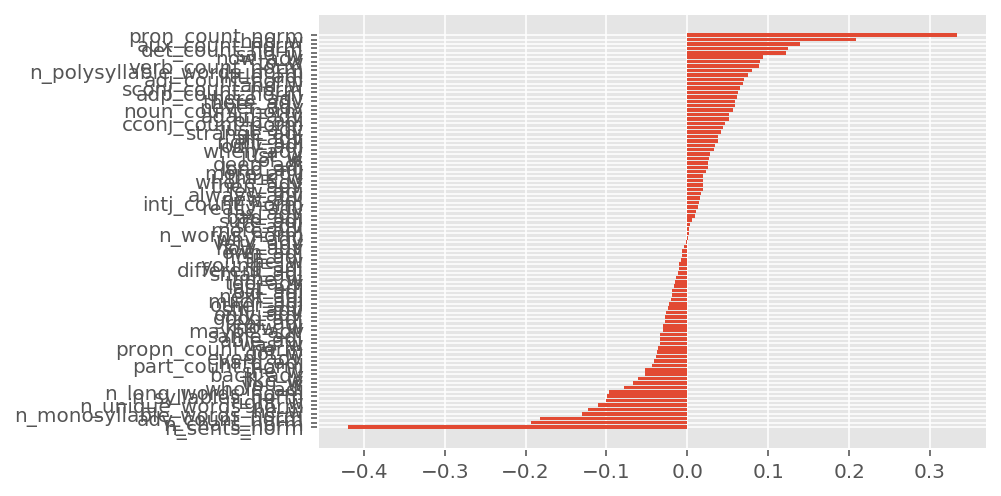

In [11]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = X_train.columns
f_importances(svm_l.model_gs.best_estimator_.coef_[1], features_names)

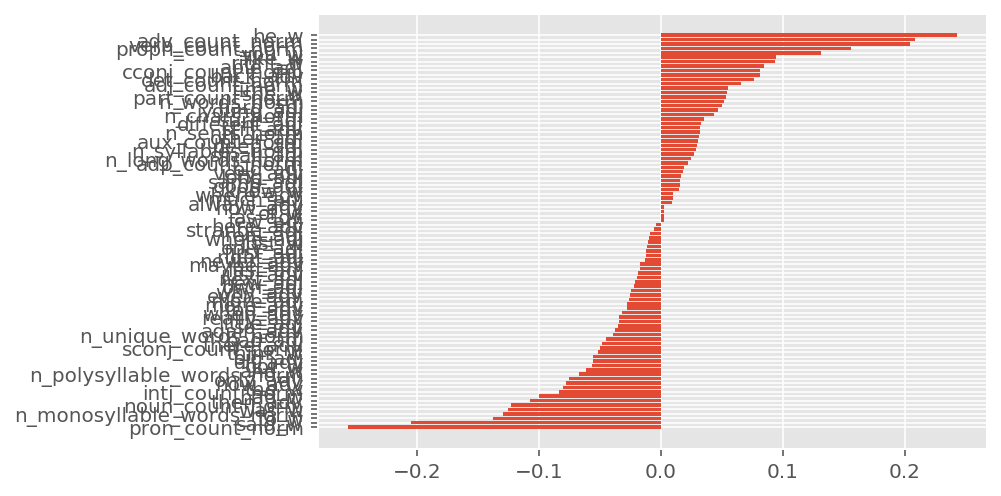

In [12]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = X_train.columns
f_importances(svm_l.model_gs.best_estimator_.coef_[2], features_names)

### Confusion Matrix